In [0]:
from google.colab import drive


from zipfile import ZipFile
from tarfile import TarFile 


import pandas as pd
import numpy as np
from numpy.random import shuffle


import cv2
import imageio
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv


import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, Flatten, Add, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Dense, Conv2D, Reshape, BatchNormalization, ReLU, Lambda
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model


from IPython import display
import sys
import time
import os

In [2]:
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
file_path='/content/gdrive/My Drives/anime_face_GAN/'

In [0]:
def mkdir(s):
    try:
        os.mkdir(file_path+s)
    except:
        return
    
    
mkdir('data/')
mkdir('photos/')
mkdir('models')
mkdir('logs/')      

Data set
---

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
''' 
#down load image
download_file_from_google_drive('1tpW7ZVNosXsIAWu8-f5EpwtF3ls3pb79',file_path+'data/data.zip')
'''

In [0]:
datafile=ZipFile(file_path+'data/data.zip','r')
file_list=datafile.infolist()
file_list=list(filter(lambda x:'.jpg' in x.filename,file_list))
imgs=[datafile.read(img) for img in file_list]
imgs=[cv2.imdecode(np.frombuffer(img,np.uint8),3) for img in imgs]
imgs=np.array(imgs)
imgs=imgs[:,:,:,::-1]

In [8]:
imgs.shape

(36740, 64, 64, 3)

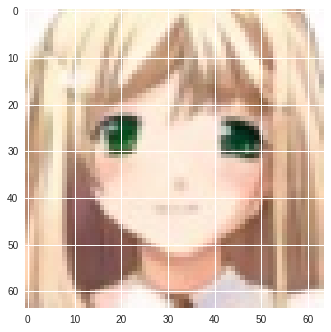

In [9]:
plt.imshow(imgs[10])

In [0]:
# image batch generator

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def get_image_batch(size):
    while True:
        shuffle(imgs)  
        for batch in chunker(imgs,size):
            if len(batch) == size:
                X=np.array(batch)/255.

                yield X

Tensorboard
---

In [6]:
#tensorboard

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-03-27 10:45:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.3.53.115, 52.4.75.11, 34.231.75.48, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.3.53.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  40.1MB/s    in 0.4s    

2019-03-27 10:45:47 (40.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [8]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://1a2f84f3.ngrok.io


Keras Model
---

In [0]:
# generator

gate=tf.placeholder(tf.float32,[4])


## up sampling
def PixelShuffler(block):
    return Lambda(lambda x: tf.nn.depth_to_space(x,block))

## convert to hsv with four channel
def hnorm(x):
    xrsqrt=tf.rsqrt(x[:,:,:,0]**2+x[:,:,:,1]**2)
    x0=x[:,:,:,0]*xrsqrt
    x1=x[:,:,:,1]*xrsqrt
    x2=tf.sigmoid(x[:,:,:,2])
    x3=tf.sigmoid(x[:,:,:,3])
    return tf.stack([x0,x1,x2,x3],axis=-1)

## normalize layer
def pixelnorm():
    def _pixelnorm(x): #(nhwc)
        xrsqrt=tf.rsqrt(tf.reduce_mean(x**2,axis=-1,keepdims=True))
        return (x*xrsqrt)
    return Lambda(_pixelnorm)
        
def featurenorm():
    def _featurenorm(x):
        xmean=tf.reduce_mean(x,axis=[1,2],keepdims=True)
        xstd=tf.keras.backend.std(x,axis=[1,2],keepdims=True)
        x=(x-xmean)/xstd
        return x
    return Lambda(_featurenorm)


## Add style
def ApplyStyle(fsize):
    
    def _applystyle(_x):

        #x[0]:image
        #s[1]:style
        
        x=_x[0]
        s=_x[1]
        ch=x.shape[-1]

        s=tf.reshape(s,[-1,2,1,1,ch])

        s1=s[:,0,:,:,:]
        s2=s[:,1,:,:,:]

        s1=tf.tile(s1,[1,x.shape[1],x.shape[2],1])
        s2=tf.tile(s2,[1,x.shape[1],x.shape[2],1])
        x=x*s1+s2

        return x

    def _as(x):
        #x[0]:img
        #x[1]:w
        
        w=Dense(fsize*2,activation='relu')(x[1])
        w=Dense(fsize*2,activation='relu')(w)
        w=Dense(fsize*2)(w)
        
        return Lambda(_applystyle)([x[0],w])
    return _as

## convert to image for each size
def OutputImage():
    def _output(x):
        x=Conv2D(filters=128,kernel_size=(1,1),padding='same',use_bias=False)(x)
        x1=Conv2D(filters=3,kernel_size=(3,3),padding='same',use_bias=False,activation='sigmoid')(x)
        return(x1)
    return _output

##
def Expend():
    def _expend(t):
        t1=tf.reshape(t,[-1,t.shape[1],1,t.shape[2],t.shape[3]])
        t2=tf.tile(t1,[1,1,2,1,1])
        t3=tf.reshape(t2,[-1,t.shape[1]*2,t.shape[2],1,t.shape[3]])
        t4=tf.tile(t3,[1,1,1,2,1])
        t5=tf.reshape(t4,[-1,t.shape[1]*2,t.shape[2]*2,t.shape[3]])
        return t5
    return Lambda(_expend)
        
def Merge(i):
    def _merge(x):
        # x[0]: higher resolution image (bhwc)
        # x[1]: lower resolution image (bhwc)

        return x[0]*gate[i]+x[1]*(1-gate[i])
    return Lambda(_merge)


In [0]:
def g_base():

    ##  z->w
    z=Input((128,))    
    d1=Dense(128,activation='relu')(z)
    d2=Dense(128,activation='relu')(d1)
    d3=Dense(128,activation='relu')(d2)
    d3=Dense(128,activation='relu')(d3)
    d3=Dense(128,activation='relu')(d3)
    w=Dense(128)(d3)
    
    gz_w=Model(z,w)
    
    # 4*4
    x0=Input((4,4,128))    
    ws=[Input((128,)) for i in range(10)]
 
    x=ApplyStyle(128)([x0,ws[0]])
    x=Conv2D(filters=128,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[1]])
    
    o4=OutputImage()(x)    
    o4=Expend()(o4)
    
    # 8*8
    x8=PixelShuffler(2)(x)
    x=Conv2D(filters=128,kernel_size=(3,3), padding='same',use_bias=False)(x8)                                                           
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[2]])
    x=Conv2D(filters=128,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[3]])
    
    o8=OutputImage()(x)    
    o8=Merge(0)([o8,o4])
    o8=Expend()(o8)
    
    
    #16*16
    x16=PixelShuffler(2)(x)
    x16=Concatenate()([x16,Expend()(x8)])
    
    x=Conv2D(filters=128,kernel_size=(3,3), padding='same',use_bias=False)(x16)                                                           
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[4]])
    x=Conv2D(filters=128,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[5]])
    
    o16=OutputImage()(x)
    o16=Merge(1)([o16,o8])
    o16=Expend()(o16)
    
    #32*32
    x32=PixelShuffler(2)(x)
    x32=Concatenate()([x32,Expend()(x16)])
    
    x=Conv2D(filters=128,kernel_size=(3,3), padding='same',use_bias=False)(x32)                                                           
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[6]])
    x=Conv2D(filters=128,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[7]])
    
    o32=OutputImage()(x)
    o32=Merge(2)([o32,o16])
    o32=Expend()(o32)
    
    
    #64*64
    x64=PixelShuffler(2)(x)
    x64=Concatenate()([x64,Expend()(x32)])
    x=Conv2D(filters=128,kernel_size=(3,3), padding='same',use_bias=False)(x64)                                                           
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[8]])
    x=Conv2D(filters=128,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=featurenorm()(x)
    x=ApplyStyle(128)([x,ws[9]])
    
    o64=OutputImage()(x)
    o64=Merge(3)([o64,o32])    
    
    ## model w->output image
    gw_i=Model(ws+[x0],o64)
    
    ## model all
    ww=gz_w(z)
    o=gw_i([ww for i in range(10)]+[x0])
    
    gm=Model([z,x0],[o,ww])
    
    return gm,gw_i


In [8]:
gm,gw_i=g_base()

gm.summary()
gw_i.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          99072       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4, 4, 128)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 64, 64, 3)    2851200     model[1][0]                      
                                     

In [0]:
# discriminator

def DownShuffler(block):
    return Lambda(lambda x:tf.nn.space_to_depth(x,block))


In [0]:

# discriminator

def d_base():
    

    inputs=Input((64,64,3))

    # 64*64    
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(inputs)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)# 64*64*64
       
    # 32*32
    x32=DownShuffler(2)(x)
    x32=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x32)
    x32=LeakyReLU()(x32)
    x32=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x32)
    x32=LeakyReLU()(x32)
    x32=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x32)
    
    
    i32=AveragePooling2D((2,2))(inputs)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(i32)
    y=LeakyReLU()(y)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(y)
    
    m32=Merge(3)([x32,y])
    
    #16*16
    
    x=DownShuffler(2)(m32)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    
    i16=AveragePooling2D((2,2))(i32)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(i16)
    y=LeakyReLU()(y)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(y)

    m16=Merge(2)([x,y])
    
    #8*8
    
    x=DownShuffler(2)(m16)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    
    i8=AveragePooling2D((2,2))(i16)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(i8)
    y=LeakyReLU()(y)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(y)

    m8=Merge(1)([x,y])    
    
    #4*4
    
    x=DownShuffler(2)(m8)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    x=LeakyReLU()(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(x)
    
    i4=AveragePooling2D((2,2))(i8)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(i4)
    y=LeakyReLU()(y)
    y=Conv2D(filters=64,kernel_size=(3,3),padding='same',use_bias=False)(y)

    m4=Merge(0)([x,y])
    
    f1=Flatten()(m4)
    
    d1=Dense(128,activation='relu')(f1)
    d2=Dense(128,activation='relu')(d1)
    out=Dense(1)(d2)
    
    input_f=Input((4*4*64,))
    dw=Dense(1024,activation='relu')(input_f)
    
    dw=Dense(1024,activation='relu')(dw)
    dw=Dense(1024,activation='relu')(dw)
    dw=Dense(128)(dw)
    
    dl=Model(inputs,out)
    dw=Model(input_f,dw)
    
    dwo=dw(f1)
    dm=Model(inputs,[out,f1,dwo])
    return dl,dw,dm

    
    

In [0]:
dl,dw,dm=d_base()


Loss and Train
---

In [0]:
## tf placeholder input

input_g=tf.placeholder(tf.float32,(None,128)) 
input_d=tf.placeholder(tf.float32,(None,64,64,3))
input_b=tf.placeholder(tf.float32,(None,4,4,128))

In [0]:
## get g and d output

g_img,g_w=gm([input_g,input_b])
d_real,_,d_w_real=dm(input_d)
d_fake,_,d_w_fake=dm(g_img)

In [14]:
## loss d
input_pena=0.5*input_d+0.5*g_img
d_pena=dm(input_pena)[0]

d_real=tf.reduce_mean(d_real)
d_fake=tf.reduce_mean(d_fake)
d_pena=tf.reduce_mean(d_pena)

loss_d_1=-d_real+d_fake
loss_d_pen=tf.gradients(d_pena,input_pena)[0]
loss_d_pen=((tf.reduce_sum(loss_d_pen**2))**(1/2)-1)**2
loss_info=tf.losses.mean_squared_error(g_w,d_w_fake)

loss_d=loss_d_1+10*loss_d_pen+loss_info

## d train
opt_d=tf.train.RMSPropOptimizer(learning_rate=1e-4)
train_d=opt_d.minimize(loss_d,var_list=dm.trainable_variables)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [0]:
# loss g

loss_g=-tf.reduce_mean(d_fake)

# reconstruct error

recon=gw_i([d_w_real for i in range(10)]+[input_b])
loss_reconstruct=tf.losses.mean_squared_error(recon,input_d)

loss_g_recon=loss_g+loss_reconstruct

# train g
opt_g=tf.train.RMSPropOptimizer(learning_rate=1e-4)
train_g=opt_g.minimize(loss_g_recon,var_list=gm.trainable_variables)

In [0]:
sess=tf.keras.backend.get_session()
sess.run(tf.global_variables_initializer())

In [0]:
gaten=np.array([1.,1.,1.,1.])

In [0]:
#load pretrained model
dm.load_weights(file_path+'models/dm28600.h5')
gm.load_weights(file_path+'models/gm28600.h5')


Tensorboard
---

In [0]:
writer = tf.summary.FileWriter("./logs/", sess.graph)
writer_gd = tf.summary.FileWriter(file_path+"logs/", sess.graph)

In [20]:
tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
tf.summary.scalar('loss_d_',loss_d_1)
tf.summary.scalar('loss_info', loss_info)
tf.summary.scalar('loss_d_pen', loss_d_pen)
tf.summary.scalar('d_real', d_real)
tf.summary.scalar('d_fake', d_fake)


<tf.Tensor 'd_fake:0' shape=() dtype=string>

In [0]:
merged = tf.summary.merge_all()

Training
---

In [0]:

try:
    g_lenten=np.load(file_path+'test.npy')
except:
    g_lenten=np.random.randn(100,128)
    np.save(file_path+'test.npy',g_lenten)


In [0]:
batch_size=64
imgg=get_image_batch(batch_size)

for epo in range(28600,30000):
    if epo%100==0:
        
        ig=sess.run(g_img,feed_dict={input_g:g_lenten,input_b:np.ones([100,4,4,128]),gate:gaten})
        ig=ig.reshape(10,10,64,64,3).swapaxes(1,2).reshape(640,640,3)*255

        file=file_path+'photos/update'+str(epo)+'.jpg'
        imageio.imwrite(file, ig)  
    if epo%100==0:
        rs=sess.run(merged,feed_dict={input_g:np.random.randn(batch_size,128),input_b:np.ones([batch_size,4,4,128]),input_d:next(imgg),gate:gaten})
        writer.add_summary(rs, epo)
        writer_gd.add_summary(rs, epo)
        
    if epo%100==0:
        dm.save(file_path+'models/dm'+str(epo)+'.h5')
        gm.save(file_path+'models/gm'+str(epo)+'.h5')
        
    sys.stdout.write("\rTraining times %i" % epo)
    sys.stdout.flush()
    
    for i in range(5):
        sess.run(train_d,feed_dict={input_g:np.random.randn(batch_size,128),input_b:np.ones([batch_size,4,4,128]),input_d:next(imgg),gate:gaten})
        
    sess.run(train_g,feed_dict={input_g:np.random.randn(batch_size,128),input_b:np.ones([batch_size,4,4,128]),gate:gaten,input_d:next(imgg),gate:gaten})
    



Training times 24399

Training times 24499

Training times 24599

Training times 24699

Training times 24799

Training times 24899

Training times 24999

Training times 25099

Training times 25199

Training times 25299

Training times 25399

Training times 25499

Training times 25599

Training times 25699

Training times 25799

Training times 25899

Training times 25999

Training times 26099

Training times 26199

Training times 26299

Training times 26399

Training times 26499

Training times 26599

Training times 26699

Training times 26799

Training times 26899

Training times 26999

Training times 27099

Training times 27199

Training times 27299

Training times 27399

Training times 27435

Application
===

generated example
---

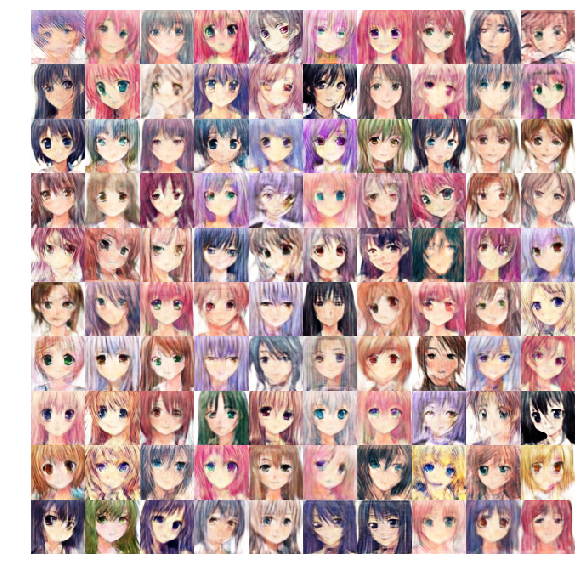

In [285]:
z_lenten=np.random.randn(100,128)/2
ig=sess.run(g_img,feed_dict={input_g:z_lenten,input_b:np.ones([100,4,4,128]),gate:gaten})
ig=ig.reshape(10,10,64,64,3).swapaxes(1,2).reshape(640,640,3)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(ig)

latent space change
---

In [0]:
def gradi(np1,np2,n):
    dif=(np2-np1)/(n-1)
    c=[np1+i*dif for i in range(n)]
    return np.array(c)

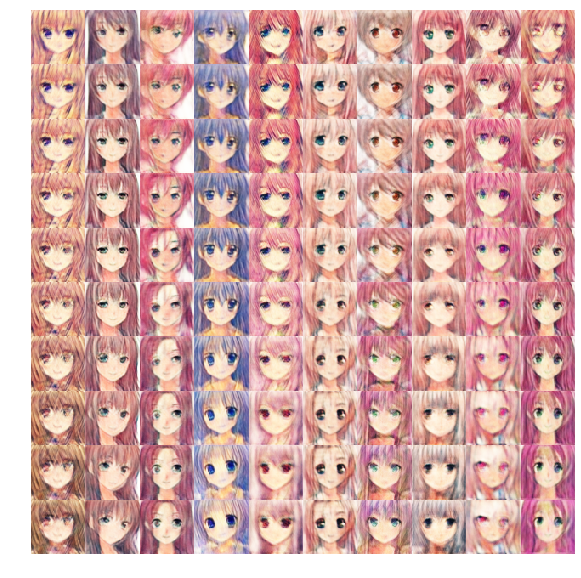

In [291]:
z_1=np.random.randn(10,128)/3
z_2=np.random.randn(10,128)/3
z_3=gradi(z_1,z_2,10).reshape(100,128)
ig=sess.run(g_img,feed_dict={input_g:z_3,input_b:np.ones([100,4,4,128]),gate:gaten})
ig=ig.reshape(10,10,64,64,3).swapaxes(1,2).reshape(640,640,3)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(ig)

reconstruct
---

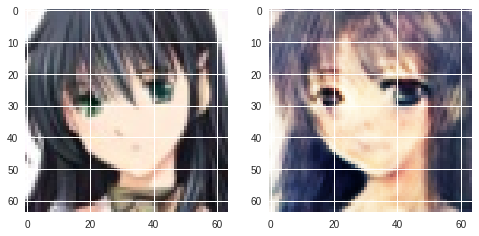

In [230]:
i=np.random.randint(20000)
p_recon=sess.run(recon,feed_dict={input_b:np.ones([1,4,4,128]),input_d:(imgs[i]/255.).reshape(1,64,64,3),gate:gaten})
ax=plt.subplot(1,2,1)
plt.imshow(imgs[i])
ax=plt.subplot(1,2,2)
plt.imshow(p_recon[0])

In [0]:
input_d2=tf.placeholder(tf.float32,(None,64,64,3))
_,_,d_w_real2=dm(input_d2)
recon2=gw_i([d_w_real for i in range(8)]+[d_w_real2 for i in range(2)]+[input_b])

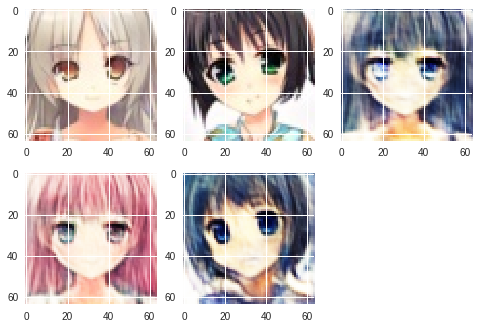

In [278]:
i=np.random.randint(20000)
j=np.random.randint(20000)
p_recon1=sess.run(recon,feed_dict={input_b:np.ones([1,4,4,128]),input_d:(imgs[i]/255.).reshape(1,64,64,3),gate:gaten})
p_recon2=sess.run(recon,feed_dict={input_b:np.ones([1,4,4,128]),input_d:(imgs[j]/255.).reshape(1,64,64,3),gate:gaten})
pm=sess.run(recon2,feed_dict={input_b:np.ones([1,4,4,128]),input_d:(imgs[i]/255.).reshape(1,64,64,3),input_d2:(imgs[j]/255.).reshape(1,64,64,3),gate:gaten})

ax=plt.subplot(2,3,1)
plt.imshow(imgs[i])
ax=plt.subplot(2,3,2)
plt.imshow(imgs[j])
ax=plt.subplot(2,3,4)
plt.imshow(p_recon1[0])
ax=plt.subplot(2,3,5)
plt.imshow(p_recon2[0])
ax=plt.subplot(2,3,3)
plt.imshow(pm[0])

In [0]:
pm=sess.run(recon2,feed_dict={input_b:np.ones([400,4,4,128]),input_d:imgs[0:400]/255.,input_d2:imgs[1:401]/255.,gate:gaten})